# 测试集图像语义特征的可视化分析

选取图像分类模型中间层的输出特征作为输入图像的语义特征。

使用t-SNE降维方法，使其语义特征降维至二维和三维。

分析不同类别的语义距离、异常数据、细粒度分类、高维数据结构。



## 安装配置环境

### 库

In [ ]:
!pip install numpy pandas scikit-learn matplotlib seaborn requests tqdm opencv-python pillow  -i https://pypi.tuna.tsinghua.edu.cn/simple

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### PyTorch

In [ ]:
!pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cu113


### 中文字体

In [ ]:
# 从 Google API 上下载暂存字体放到暂存文件夹下

!wget 'https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKtc-hinted.zip'
!mkdir /tmp/fonts
!unzip -o NotoSansCJKtc-hinted.zip -d /tmp/fonts/
!mv /tmp/fonts/NotoSansMonoCJKtc-Regular.otf /usr/share/fonts/truetype/NotoSansMonoCJKtc-Regular.otf -f
!rm -rf /tmp/fonts
!rm NotoSansCJKtc-hinted.zip

--2023-01-24 02:02:59--  https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKtc-hinted.zip
Resolving noto-website-2.storage.googleapis.com (noto-website-2.storage.googleapis.com)... 142.250.145.128, 2a00:1450:4013:c14::80
Connecting to noto-website-2.storage.googleapis.com (noto-website-2.storage.googleapis.com)|142.250.145.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 121247366 (116M) [application/zip]
Saving to: ‘NotoSansCJKtc-hinted.zip’

NotoSansCJKtc-hinte 100%[===================>] 115.63M  32.4MB/s    in 3.6s    

2023-01-24 02:03:03 (32.4 MB/s) - ‘NotoSansCJKtc-hinted.zip’ saved [121247366/121247366]

Archive:  NotoSansCJKtc-hinted.zip
  inflating: /tmp/fonts/LICENSE_OFL.txt  
  inflating: /tmp/fonts/NotoSansCJKtc-Black.otf  
  inflating: /tmp/fonts/NotoSansCJKtc-Bold.otf  
  inflating: /tmp/fonts/NotoSansCJKtc-DemiLight.otf  
  inflating: /tmp/fonts/NotoSansCJKtc-Light.otf  
  inflating: /tmp/fonts/NotoSansCJKtc-Medium.otf  
  inflatin

In [ ]:
# 指定字体
import matplotlib.font_manager as font_manager
import matplotlib.pyplot as plt
 
font_dirs = ['/usr/share/fonts/truetype/']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
 
for font_file in font_files:
  font_manager.fontManager.addfont(font_file)
 
plt.rcParams['font.family'] = "Noto Sans Mono CJK TC"

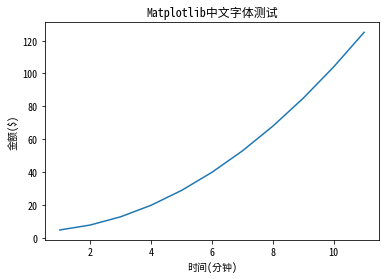

In [ ]:
#测试
import numpy as np
import matplotlib.pyplot as plt
 
 
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
 
x = np.arange(1, 12)
y = x ** 2 + 4
plt.title("Matplotlib中文字体测试")
plt.xlabel("时间(分钟)")
plt.ylabel("金额($)")
plt.plot(x,y)
plt.show()

### 加载图像分类模型和数据

In [ ]:
# 下载数据集压缩包
!wget https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20220716-mmclassification/dataset/fruit30/fruit30_split.zip

# 解压
!unzip fruit30_split.zip >> /dev/null

# 删除压缩包
!rm fruit30_split.zip



--2023-01-24 02:03:05--  https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20220716-mmclassification/dataset/fruit30/fruit30_split.zip
Resolving zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com (zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com)... 121.36.235.132
Connecting to zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com (zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com)|121.36.235.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 226278151 (216M) [application/zip]
Saving to: ‘fruit30_split.zip’

fruit30_split.zip   100%[===================>] 215.79M  9.86MB/s    in 20s     

2023-01-24 02:03:26 (10.9 MB/s) - ‘fruit30_split.zip’ saved [226278151/226278151]



In [ ]:
# 下载 类别名称 和 ID索引号 的映射字典
!wget https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20220716-mmclassification/dataset/fruit30/idx_to_labels.npy

--2023-01-24 02:03:30--  https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20220716-mmclassification/dataset/fruit30/idx_to_labels.npy
Resolving zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com (zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com)... 121.36.235.132
Connecting to zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com (zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com)|121.36.235.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 769 [binary/octet-stream]
Saving to: ‘idx_to_labels.npy’

idx_to_labels.npy   100%[===================>]     769  --.-KB/s    in 0.003s  

2023-01-24 02:03:31 (259 KB/s) - ‘idx_to_labels.npy’ saved [769/769]



In [ ]:
# 下载样例模型文件
!wget https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20220716-mmclassification/checkpoints/fruit30_pytorch_20220814.pth -P checkpoints

--2023-01-24 02:03:31--  https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20220716-mmclassification/checkpoints/fruit30_pytorch_20220814.pth
Resolving zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com (zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com)... 121.36.235.132
Connecting to zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com (zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com)|121.36.235.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 44854477 (43M) [binary/octet-stream]
Saving to: ‘checkpoints/fruit30_pytorch_20220814.pth’

fruit30_pytorch_202 100%[===================>]  42.78M  11.2MB/s    in 5.2s    

2023-01-24 02:03:37 (8.21 MB/s) - ‘checkpoints/fruit30_pytorch_20220814.pth’ saved [44854477/44854477]



# 正式开始！

In [ ]:
import os
from tqdm import tqdm

import pandas as pd
import numpy as np

import cv2
from PIL import Image

# 忽略烦人的红色提示
import warnings
warnings.filterwarnings("ignore")

import os
from tqdm import tqdm

import torch
import torch.nn.functional as F

# 有 GPU 就用 GPU，没有就用 CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device', device)

device cuda:0


## 图像预处理

In [ ]:
from torchvision import transforms


# 测试集图像预处理-RCTN：缩放、裁剪、转 Tensor、归一化
test_transform = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(
                                         mean=[0.485, 0.456, 0.406], 
                                         std=[0.229, 0.224, 0.225])
                                    ])

## 重新载入表格和导入模型参数

In [ ]:
# 此处经过尝试，需重新运行生成 '测试集预测结果.csv' 的代码，否则将在后续可视化过程中出现某些隐藏文件没有生成的bug

In [ ]:
# 数据集文件夹路径

dataset_dir = 'fruit30_split'
test_path = os.path.join(dataset_dir, 'val')

# 载入测试集

from torchvision import datasets
test_dataset = datasets.ImageFolder(test_path, test_transform)

print('测试集图像数量', len(test_dataset))
print('类别个数', len(test_dataset.classes))
print('各类别名称', test_dataset.classes)

# 载入类别名称 和 ID索引号 的映射字典

idx_to_labels = np.load('idx_to_labels.npy', allow_pickle=True).item()
# allow_pickle: 可选，表示是否使用布尔值，允许使用 Python pickles 保存对象数组
# Python 中的 pickle 用于在保存到磁盘文件或从磁盘文件读取之前，将对象进行序列化和反序列化。

测试集图像数量 1078
类别个数 30
各类别名称 ['哈密瓜', '圣女果', '山竹', '杨梅', '柚子', '柠檬', '桂圆', '梨', '椰子', '榴莲', '火龙果', '猕猴桃', '石榴', '砂糖橘', '胡萝卜', '脐橙', '芒果', '苦瓜', '苹果-红', '苹果-青', '草莓', '荔枝', '菠萝', '葡萄-白', '葡萄-红', '西瓜', '西红柿', '车厘子', '香蕉', '黄瓜']


In [ ]:
# 获得类别名称

classes = list(idx_to_labels.values())
print(classes)

['哈密瓜', '圣女果', '山竹', '杨梅', '柚子', '柠檬', '桂圆', '梨', '椰子', '榴莲', '火龙果', '猕猴桃', '石榴', '砂糖橘', '胡萝卜', '脐橙', '芒果', '苦瓜', '苹果-红', '苹果-青', '草莓', '荔枝', '菠萝', '葡萄-白', '葡萄-红', '西瓜', '西红柿', '车厘子', '香蕉', '黄瓜']


In [ ]:
# 导入训练好的模型

model = torch.load('checkpoints/fruit30_pytorch_20220814.pth')
model = model.eval().to(device)

In [ ]:
# 利用test_dataset返回预处理后的前10张图片路径及其标签

test_dataset.imgs[:10]

[('fruit30_split/val/哈密瓜/106.jpg', 0),
 ('fruit30_split/val/哈密瓜/109.jpg', 0),
 ('fruit30_split/val/哈密瓜/114.jpg', 0),
 ('fruit30_split/val/哈密瓜/116.jpg', 0),
 ('fruit30_split/val/哈密瓜/118.png', 0),
 ('fruit30_split/val/哈密瓜/123.jpg', 0),
 ('fruit30_split/val/哈密瓜/127.jpg', 0),
 ('fruit30_split/val/哈密瓜/129.jpg', 0),
 ('fruit30_split/val/哈密瓜/131.jpg', 0),
 ('fruit30_split/val/哈密瓜/133.jpg', 0)]

In [ ]:
# 获取每一个预处理图像的路径

img_paths = [each[0] for each in test_dataset.imgs] # 只返回test_dataset.imgs中的图像路径

In [ ]:
# 创建一个pandas表格df保存图像路径、ID与名称

df = pd.DataFrame()
df['图像路径'] = img_paths
df['标注类别ID'] = test_dataset.targets
df['标注类别名称'] = [idx_to_labels[ID] for ID in test_dataset.targets]

In [ ]:
# 记录 top-n 预测结果
# 显示每张图片的预测结果及其置信度大小

n = 3
# 创建一个pandas表格 df_pred 保存图片预测结果及其置信度

df_pred = pd.DataFrame()
for idx, row in tqdm(df.iterrows()): # 对df表格依次处理
    img_path = row['图像路径']
    img_pil = Image.open(img_path).convert('RGB') 
    input_img = test_transform(img_pil).unsqueeze(0).to(device) # 预处理
    pred_logits = model(input_img) # 执行前向预测，得到所有类别的 logit 预测分数
    pred_softmax = F.softmax(pred_logits, dim=1) # 对 logit 分数做 softmax 运算

    pred_dict = {}

    top_n = torch.topk(pred_softmax, n) # 利用topk取置信度最大的 n 个结果
    pred_ids = top_n[1].cpu().detach().numpy().squeeze() # 解析出最高置信度所对应的类别
    
    # top-n 预测结果
    for i in range(1, n+1):
        pred_dict['top-{}-预测ID'.format(i)] = pred_ids[i-1] # 依次获取各个 top_n 所对应的ID
        pred_dict['top-{}-预测名称'.format(i)] = idx_to_labels[pred_ids[i-1]] # 对照 idx-labels 获取名称
    pred_dict['top-n预测正确'] = row['标注类别ID'] in pred_ids # 如果 pred_ids 中有一个与 标注类别ID 相同则在 topn-预测正确 上记录“1"

    # 计算30个类别每个类别的预测置信度
    for idx, each in enumerate(classes): 
    # enumerate()函数用于将一个可遍历的数据对象（如列表、元组或字符串）组合为一个索引序列，同时列出数据和数据下标，一般用在for循环当中
    # 此处idx与索引序列相互对应
        pred_dict['{}-预测置信度'.format(each)] = pred_softmax[0][idx].cpu().detach().numpy()
        
    df_pred = df_pred.append(pred_dict, ignore_index=True) # index 表示表格中的索引

1078it [00:26, 41.20it/s]


In [ ]:
df = pd.concat([df, df_pred], axis=1) # 按左右（行）方向拼接两个表格

In [ ]:
df.to_csv('测试集预测结果.csv', index=False)

In [ ]:
# 导入工具包
import pandas as pd
import numpy as np
from tqdm import tqdm

In [ ]:
# 载入idx_to_labels的numpy array
idx_to_labels = np.load('idx_to_labels.npy', allow_pickle=True).item()
# item()函数的作用是从包含单个元素的张量中取出该元素值，并保持该元素的类型不变。即：该元素为整形，则返回整形，该元素为浮点型，则返回浮点型
# 此处利用item()返回标准的python标量，加快读取速度

# 获得类别名称
classes = list(idx_to_labels.values())
# values() 方法以列表形式（并非直接的列表，若要返回列表值还需调用list函数）返回字典中的所有值。
print(classes)

['哈密瓜', '圣女果', '山竹', '杨梅', '柚子', '柠檬', '桂圆', '梨', '椰子', '榴莲', '火龙果', '猕猴桃', '石榴', '砂糖橘', '胡萝卜', '脐橙', '芒果', '苦瓜', '苹果-红', '苹果-青', '草莓', '荔枝', '菠萝', '葡萄-白', '葡萄-红', '西瓜', '西红柿', '车厘子', '香蕉', '黄瓜']


## 语义特征的选取

In [ ]:
from torchvision.models.feature_extraction import create_feature_extractor

In [ ]:
# 从分类层前一层（avgpool）选取语义特征

model_trunc = create_feature_extractor(model, return_nodes={'avgpool': 'semantic_feature'})

In [ ]:
# 具体查看图像分类模型的网络结构

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## 计算单张图像的语义特征

In [ ]:
img_path = 'fruit30_split/val/西红柿/100.jpg'
img_pil = Image.open(img_path)
input_img = test_transform(img_pil) # 预处理
input_img = input_img.unsqueeze(0).to(device)
# 执行前向预测，得到指定中间层的输出

pred_logits = model_trunc(input_img) # 输出 输入图像语义特征 对应的置信度

In [ ]:
pred_logits['semantic_feature'].squeeze().detach().cpu().numpy().shape # 此处维度对应与最后的FC输入维度

(512,)

In [ ]:
pred_logits['semantic_feature'].squeeze().detach().cpu().numpy()

array([7.99214691e-02, 1.84395418e-01, 5.23652375e-01, 2.26355672e+00,
       9.59886253e-01, 1.58902407e-01, 1.25098431e+00, 3.59807909e-01,
       1.09926653e+00, 1.18580651e+00, 1.77748263e+00, 9.78782296e-01,
       5.15610397e-01, 1.96975839e+00, 2.01867700e-01, 6.13462448e-01,
       2.45352411e+00, 9.33379710e-01, 5.39205857e-02, 8.78693104e-01,
       2.72935718e-01, 3.17928493e-01, 4.34739202e-01, 1.92015564e+00,
       1.67997897e+00, 2.44037390e-01, 8.73573422e-01, 5.36355853e-01,
       1.16799033e+00, 2.45385218e+00, 1.54415584e+00, 3.41308489e-02,
       2.57374382e+00, 8.01510692e-01, 1.48794961e+00, 6.29642382e-02,
       1.37602913e+00, 1.13698006e+00, 6.78009331e-01, 1.43019307e+00,
       2.14852810e+00, 7.19561577e-01, 1.64405417e+00, 1.28905916e+00,
       2.72534370e-01, 1.75863957e+00, 1.11761904e+00, 2.74777031e+00,
       9.26478058e-02, 1.83552518e-01, 9.11458135e-01, 1.83556902e+00,
       1.70073545e+00, 1.06421977e-01, 1.90137550e-01, 7.59755194e-01,
      

## 载入测试集图像分类结果

In [ ]:
df = pd.read_csv('测试集预测结果.csv')

In [ ]:
df

,图像路径,标注类别ID,标注类别名称,top-1-预测ID,top-1-预测名称,top-2-预测ID,top-2-预测名称,top-3-预测ID,top-3-预测名称,top-n预测正确,...,草莓-预测置信度,荔枝-预测置信度,菠萝-预测置信度,葡萄-白-预测置信度,葡萄-红-预测置信度,西瓜-预测置信度,西红柿-预测置信度,车厘子-预测置信度,香蕉-预测置信度,黄瓜-预测置信度
0,fruit30_split/val/哈密瓜/106.jpg,0,哈密瓜,4.0,柚子,5.0,柠檬,7.0,梨,0.0,...,1.810180e-07,1.220430e-06,3.081695e-06,9.949587e-06,5.682663e-06,0.000111,1.294234e-04,3.994169e-07,4.388279e-06,5.830779e-07
1,fruit30_split/val/哈密瓜/109.jpg,0,哈密瓜,6.0,桂圆,0.0,哈密瓜,8.0,椰子,1.0,...,8.460106e-08,1.464782e-06,1.080959e-06,1.481478e-03,4.521657e-05,0.000175,7.725531e-07,3.171621e-06,3.334372e-05,2.559102e-06
2,fruit30_split/val/哈密瓜/114.jpg,0,哈密瓜,0.0,哈密瓜,26.0,西红柿,23.0,葡萄-白,1.0,...,9.829238e-03,7.686850e-03,1.149625e-03,4.022941e-02,3.518655e-02,0.001550,2.761090e-01,1.695513e-04,6.084338e-03,1.219462e-03
3,fruit30_split/val/哈密瓜/116.jpg,0,哈密瓜,0.0,哈密瓜,16.0,芒果,4.0,柚子,1.0,...,4.417809e-05,2.469878e-04,7.062952e-05,1.455010e-03,2.550506e-06,0.000460,8.358287e-04,2.168989e-07,2.208574e-02,4.123425e-04
4,fruit30_split/val/哈密瓜/118.png,0,哈密瓜,4.0,柚子,11.0,猕猴桃,23.0,葡萄-白,0.0,...,7.725821e-04,7.507994e-05,8.939829e-05,9.169770e-02,6.589454e-04,0.000463,3.796566e-03,3.087182e-08,3.057006e-04,5.176176e-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1073,fruit30_split/val/黄瓜/87.jpg,29,黄瓜,29.0,黄瓜,25.0,西瓜,17.0,苦瓜,1.0,...,2.324817e-08,2.404210e-10,1.706871e-09,1.515922e-05,3.700694e-10,0.000765,5.824745e-07,3.420418e-09,2.065712e-07,9.991691e-01
1074,fruit30_split/val/黄瓜/9.jpg,29,黄瓜,29.0,黄瓜,17.0,苦瓜,19.0,苹果-青,1.0,...,9.939119e-08,3.520851e-09,9.062655e-09,3.705637e-07,2.155820e-08,0.000002,6.122858e-08,2.043131e-08,7.604227e-07,9.997714e-01
1075,fruit30_split/val/黄瓜/91.png,29,黄瓜,29.0,黄瓜,17.0,苦瓜,23.0,葡萄-白,1.0,...,2.775496e-04,5.867743e-04,1.002066e-04,5.684910e-03,4.514654e-04,0.000013,1.357058e-04,5.936666e-07,3.697732e-04,9.494443e-01
1076,fruit30_split/val/黄瓜/94.jpg,29,黄瓜,29.0,黄瓜,17.0,苦瓜,10.0,火龙果,1.0,...,4.145333e-04,1.798972e-06,9.843629e-05,8.981239e-04,3.303266e-04,0.001259,4.585381e-05,3.979251e-06,9.182563e-05,9.849866e-01


## 计算测试集每张图像的语义特征

In [ ]:
encoding_array = [] # 用于存取各个语义特征的置信度
img_path_list = [] # 用于存放各张图片

for img_path in tqdm(df['图像路径']):
    img_path_list.append(img_path)
    img_pil = Image.open(img_path).convert('RGB')
    input_img = test_transform(img_pil).unsqueeze(0).to(device) # 预处理
    feature = model_trunc(input_img)['semantic_feature'].squeeze().detach().cpu().numpy() # 执行前向预测，得到 avgpool 层输出的语义特征
    encoding_array.append(feature)
encoding_array = np.array(encoding_array)

100%|██████████| 1078/1078 [00:12<00:00, 86.28it/s]


In [ ]:
encoding_array.shape

(1078, 512)

In [ ]:
encoding_array[0]

array([0.21522999, 0.43751988, 0.0400261 , 1.005277  , 0.6631528 ,
       3.096282  , 0.25357926, 0.35022098, 0.8383841 , 0.10753203,
       2.053263  , 0.42785084, 0.69921   , 0.76854295, 1.0142152 ,
       0.2968931 , 0.76460063, 0.70887125, 1.1251459 , 0.07172146,
       2.7317648 , 1.183113  , 0.17651711, 0.24432583, 0.23810104,
       0.64721805, 2.165682  , 0.8314179 , 3.3074658 , 0.06172203,
       2.8790245 , 1.6655413 , 3.0167851 , 0.78355104, 1.2102749 ,
       0.6112124 , 0.50497854, 0.47580367, 0.39172494, 1.0799031 ,
       0.8701092 , 0.33326274, 0.3069662 , 2.0924096 , 0.34108645,
       1.127423  , 2.2384183 , 2.6270916 , 0.42673847, 1.5318716 ,
       0.981562  , 0.4749964 , 1.724851  , 1.1449798 , 0.1338355 ,
       0.70052034, 0.9848037 , 0.6474285 , 0.71042037, 2.8619807 ,
       0.1028066 , 1.0700767 , 0.7066836 , 3.9163065 , 0.3803228 ,
       0.49267516, 0.19062297, 1.7738476 , 0.6992908 , 0.6598028 ,
       2.6241245 , 3.5966249 , 2.6204479 , 1.1416442 , 0.31418

In [ ]:
img_path_list

['fruit30_split/val/哈密瓜/106.jpg',
 'fruit30_split/val/哈密瓜/109.jpg',
 'fruit30_split/val/哈密瓜/114.jpg',
 'fruit30_split/val/哈密瓜/116.jpg',
 'fruit30_split/val/哈密瓜/118.png',
 'fruit30_split/val/哈密瓜/123.jpg',
 'fruit30_split/val/哈密瓜/127.jpg',
 'fruit30_split/val/哈密瓜/129.jpg',
 'fruit30_split/val/哈密瓜/131.jpg',
 'fruit30_split/val/哈密瓜/133.jpg',
 'fruit30_split/val/哈密瓜/136.jpg',
 'fruit30_split/val/哈密瓜/137.jpg',
 'fruit30_split/val/哈密瓜/14.jpg',
 'fruit30_split/val/哈密瓜/144.jpg',
 'fruit30_split/val/哈密瓜/145.jpg',
 'fruit30_split/val/哈密瓜/152.jpg',
 'fruit30_split/val/哈密瓜/163.jpg',
 'fruit30_split/val/哈密瓜/164.jpg',
 'fruit30_split/val/哈密瓜/173.jpg',
 'fruit30_split/val/哈密瓜/178.jpg',
 'fruit30_split/val/哈密瓜/182.jpg',
 'fruit30_split/val/哈密瓜/25.jpg',
 'fruit30_split/val/哈密瓜/29.png',
 'fruit30_split/val/哈密瓜/38.jpg',
 'fruit30_split/val/哈密瓜/44.jpg',
 'fruit30_split/val/哈密瓜/46.jpg',
 'fruit30_split/val/哈密瓜/48.jpg',
 'fruit30_split/val/哈密瓜/56.jpg',
 'fruit30_split/val/哈密瓜/63.jpg',
 'fruit30_split/val/哈密瓜

## 保存为本地的.npy文件

In [ ]:
# 保存为本地的 npy 文件
np.save('测试集语义特征.npy', encoding_array)

## 利用t-SNE进行降维可视化

In [ ]:
# 导入工具包

import numpy as np
import pandas as pd
import cv2

In [ ]:
# 载入测试集语义特征

encoding_array = np.load('测试集语义特征.npy', allow_pickle=True)

In [ ]:
df = pd.read_csv('测试集预测结果.csv')

In [ ]:
df.head()

,图像路径,标注类别ID,标注类别名称,top-1-预测ID,top-1-预测名称,top-2-预测ID,top-2-预测名称,top-3-预测ID,top-3-预测名称,top-n预测正确,...,草莓-预测置信度,荔枝-预测置信度,菠萝-预测置信度,葡萄-白-预测置信度,葡萄-红-预测置信度,西瓜-预测置信度,西红柿-预测置信度,车厘子-预测置信度,香蕉-预测置信度,黄瓜-预测置信度
0,fruit30_split/val/哈密瓜/106.jpg,0,哈密瓜,4.0,柚子,5.0,柠檬,7.0,梨,0.0,...,1.810180e-07,0.000001,0.000003,0.000010,0.000006,0.000111,1.294234e-04,3.994169e-07,0.000004,5.830779e-07
1,fruit30_split/val/哈密瓜/109.jpg,0,哈密瓜,6.0,桂圆,0.0,哈密瓜,8.0,椰子,1.0,...,8.460106e-08,0.000001,0.000001,0.001481,0.000045,0.000175,7.725531e-07,3.171621e-06,0.000033,2.559102e-06
2,fruit30_split/val/哈密瓜/114.jpg,0,哈密瓜,0.0,哈密瓜,26.0,西红柿,23.0,葡萄-白,1.0,...,9.829238e-03,0.007687,0.001150,0.040229,0.035187,0.001550,2.761090e-01,1.695513e-04,0.006084,1.219462e-03
3,fruit30_split/val/哈密瓜/116.jpg,0,哈密瓜,0.0,哈密瓜,16.0,芒果,4.0,柚子,1.0,...,4.417809e-05,0.000247,0.000071,0.001455,0.000003,0.000460,8.358287e-04,2.168989e-07,0.022086,4.123425e-04
4,fruit30_split/val/哈密瓜/118.png,0,哈密瓜,4.0,柚子,11.0,猕猴桃,23.0,葡萄-白,0.0,...,7.725821e-04,0.000075,0.000089,0.091698,0.000659,0.000463,3.796566e-03,3.087182e-08,0.000306,5.176176e-04


In [ ]:
classes = df['标注类别名称'].unique()
print(classes)

['哈密瓜' '圣女果' '山竹' '杨梅' '柚子' '柠檬' '桂圆' '梨' '椰子' '榴莲' '火龙果' '猕猴桃' '石榴' '砂糖橘'
 '胡萝卜' '脐橙' '芒果' '苦瓜' '苹果-红' '苹果-青' '草莓' '荔枝' '菠萝' '葡萄-白' '葡萄-红' '西瓜'
 '西红柿' '车厘子' '香蕉' '黄瓜']


### 可视化配置

In [ ]:
import seaborn as sns
# 设置marker的参数，可在plotly.scatter中找到与之对应的线形

marker_list = ['.', ',', 'o', 'v', '^', '<', '>', '1', '2', '3', '4', '8', 's', 'p', 'P', '*', 'h', 'H', '+', 'x', 'X', 'D', 'd', '|', '_', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

In [ ]:
len(marker_list)

37

In [ ]:
class_list = np.unique(df['标注类别名称'])

In [ ]:
class_list

array(['哈密瓜', '圣女果', '山竹', '杨梅', '柚子', '柠檬', '桂圆', '梨', '椰子', '榴莲', '火龙果',
       '猕猴桃', '石榴', '砂糖橘', '胡萝卜', '脐橙', '芒果', '苦瓜', '苹果-红', '苹果-青', '草莓',
       '荔枝', '菠萝', '葡萄-白', '葡萄-红', '西瓜', '西红柿', '车厘子', '香蕉', '黄瓜'],
      dtype=object)

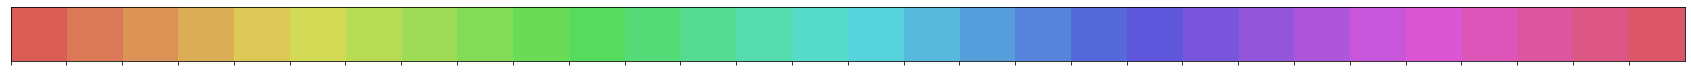

In [ ]:
n_class = len(class_list) # 测试集标签类别数
palette = sns.hls_palette(n_class) # 根据class_list进行不同类别配色方案的选取

sns.palplot(palette)

### t-SNE降至二维

In [ ]:
# 使用t-SNE降维至二维
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, n_iter=20000)
# n_components：int，可选（默认值：2）嵌入式空间的维度
# n_iter：int，可选（默认值：1000）优化的最大迭代次数。至少应该200


X_tsne_2d = tsne.fit_transform(encoding_array) # 对encoding_array中的各个图像语义特征进行t-SNE的transform

In [ ]:
X_tsne_2d.shape # 总共1078张图片，维度为2

(1078, 2)

In [ ]:
X_tsne_2d[0] # 可理解为映射到二维平面上的x，y坐标

array([ 3.2686868, -4.313902 ], dtype=float32)

In [ ]:
show_feature = '标注类别名称'

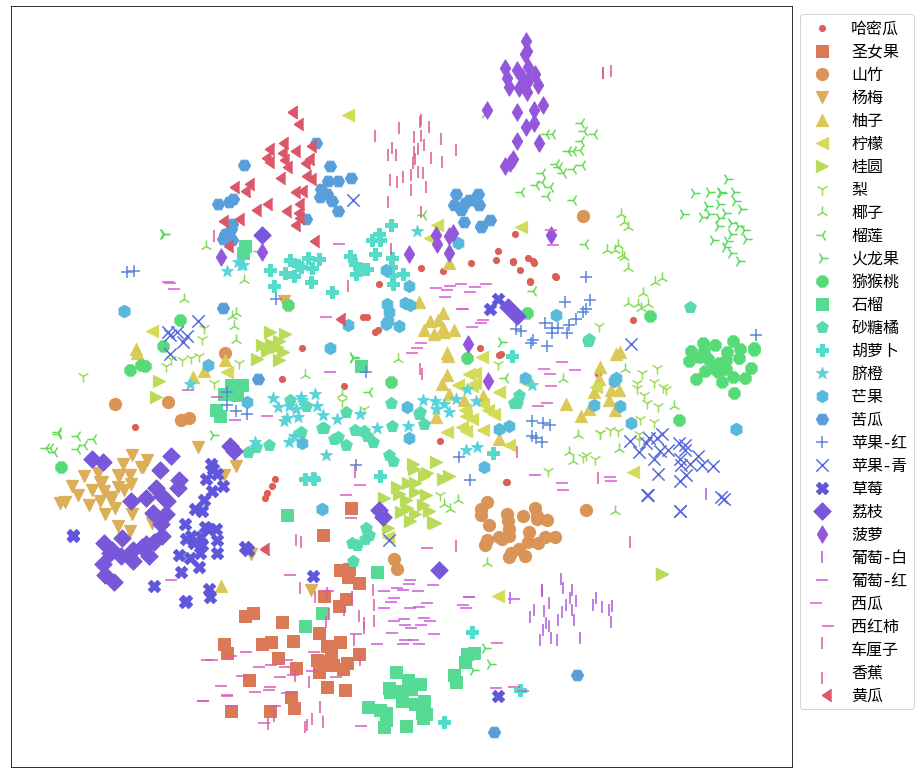

In [ ]:
# 利用matplotlib进行图像的可视化

plt.figure(figsize=(14, 14))
for idx, fruit in enumerate(class_list): # 遍历每个类别
    # 获取对应id的颜色和点型

    color = palette[idx]
    marker = marker_list[idx%len(marker_list)]
    # 找到所有标注类别为当前类别的图像索引号
    
   
    indices = np.where(df[show_feature] == fruit)
    # 此处indices起到一个索引的作用
    # np.where(condition) 当where内只有一个参数时，那个参数表示条件，当条件成立时，where返回的是每个符合condition条件元素的坐标,返回的是以元组的形式 

    plt.scatter(X_tsne_2d[indices, 0], X_tsne_2d[indices, 1], color=color, marker=marker, label=fruit, s=150)
    # 利用plt.scatter绘制散点图,其坐标选为X_tsne的横纵坐标
    # s：表示的是大小，是一个标量或者是一个shape大小为(n,)的数组，可选，默认20，数字越大表示大小越大
    # label:各个水果的名称
    
plt.legend(fontsize=16, markerscale=1, bbox_to_anchor=(1, 1))
plt.xticks([])
plt.yticks([])
plt.savefig('语义特征t-SNE二维降维可视化.pdf', dpi=300) # 保存图像
plt.show()

### 利用plotly进行可视化

In [ ]:
import plotly.express as px

In [ ]:
# 创建一个dataframe存储利用t-SNE降维至2维的信息

df_2d = pd.DataFrame()
df_2d['X'] = list(X_tsne_2d[:, 0].squeeze())
df_2d['Y'] = list(X_tsne_2d[:, 1].squeeze())
df_2d['标注类别名称'] = df['标注类别名称']
df_2d['预测类别'] = df['top-1-预测名称']
df_2d['图像路径'] = df['图像路径']
df_2d.to_csv('t-SNE-2D.csv', index=False)

In [ ]:
df_2d

,X,Y,标注类别名称,预测类别,图像路径
0,3.268687,-4.313902,哈密瓜,柚子,fruit30_split/val/哈密瓜/106.jpg
1,-9.034163,3.566452,哈密瓜,桂圆,fruit30_split/val/哈密瓜/109.jpg
2,11.074774,8.090659,哈密瓜,哈密瓜,fruit30_split/val/哈密瓜/114.jpg
3,12.875888,25.359812,哈密瓜,哈密瓜,fruit30_split/val/哈密瓜/116.jpg
4,-16.948767,4.495328,哈密瓜,柚子,fruit30_split/val/哈密瓜/118.png
...,...,...,...,...,...
1073,-15.436127,41.103199,黄瓜,黄瓜,fruit30_split/val/黄瓜/87.jpg
1074,-14.495075,33.685539,黄瓜,黄瓜,fruit30_split/val/黄瓜/9.jpg
1075,-23.713587,32.057270,黄瓜,黄瓜,fruit30_split/val/黄瓜/91.png
1076,-14.063119,36.034405,黄瓜,黄瓜,fruit30_split/val/黄瓜/94.jpg


In [ ]:
# 利用plotly的scatter绘制可交互的散点图，可实现与pandas的互联

fig = px.scatter(df_2d, 
                 x='X', 
                 y='Y',
                 color=show_feature, 
                 labels=show_feature,
                 symbol=show_feature, 
                 hover_name='图像路径',
                 opacity=0.8, # opacity表示透明度。
                 width=1000, 
                 height=600
                )

# 设置排版
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()
fig.write_html('语义特征t-SNE二维降维plotly可视化.html')

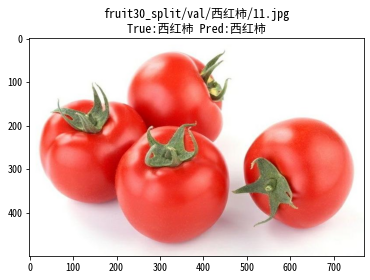

In [ ]:
# 查看图像

img_path_temp = 'fruit30_split/val/西红柿/11.jpg'
img_bgr = cv2.imread(img_path_temp)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
# 注意用matplotlib和pillow显示图片是RGB格式，而如果用OpenCV显示则是BGR格式

plt.imshow(img_rgb) # 用来显示选取的图片

temp_df = df[df['图像路径'] == img_path_temp]
title_str = img_path_temp + '\nTrue:' + temp_df['标注类别名称'].item() + ' Pred:' + temp_df['top-1-预测名称'].item()
plt.title(title_str)
plt.show()

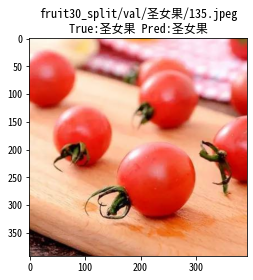

In [ ]:
# 查看图像

img_path_temp = 'fruit30_split/val/圣女果/135.jpeg'
img_bgr = cv2.imread(img_path_temp)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
# 注意用matplotlib和pillow显示图片是RGB格式，而如果用OpenCV显示则是BGR格式

plt.imshow(img_rgb) # 用来显示选取的图片

temp_df = df[df['图像路径'] == img_path_temp]
title_str = img_path_temp + '\nTrue:' + temp_df['标注类别名称'].item() + ' Pred:' + temp_df['top-1-预测名称'].item()
plt.title(title_str)
plt.show()

### t-SNE降至三维

In [ ]:
# 按照同样的方法，再利用t-SNE降维至三维

from sklearn.manifold import TSNE
tsne = TSNE(n_components=3, n_iter=10000)
X_tsne_3d = tsne.fit_transform(encoding_array)

In [ ]:
X_tsne_3d.shape

(1078, 3)

In [ ]:
show_feature = '标注类别名称'
# show_feature = '预测类别'

In [ ]:
df_3d = pd.DataFrame()
df_3d['X'] = list(X_tsne_3d[:, 0].squeeze())
df_3d['Y'] = list(X_tsne_3d[:, 1].squeeze())
df_3d['Z'] = list(X_tsne_3d[:, 2].squeeze())
df_3d['标注类别名称'] = df['标注类别名称']
df_3d['预测类别'] = df['top-1-预测名称']
df_3d['图像路径'] = df['图像路径']
df_3d.to_csv('t-SNE-3D.csv', index=False)

In [ ]:
df_3d

,X,Y,Z,标注类别名称,预测类别,图像路径
0,128.087540,25.126081,423.638275,哈密瓜,柚子,fruit30_split/val/哈密瓜/106.jpg
1,-280.265045,12.519492,-22.536226,哈密瓜,桂圆,fruit30_split/val/哈密瓜/109.jpg
2,53.024647,60.513237,71.100372,哈密瓜,哈密瓜,fruit30_split/val/哈密瓜/114.jpg
3,-129.646347,-101.531372,317.075928,哈密瓜,哈密瓜,fruit30_split/val/哈密瓜/116.jpg
4,22.241026,-35.730747,-158.371582,哈密瓜,柚子,fruit30_split/val/哈密瓜/118.png
...,...,...,...,...,...,...
1073,-27.925035,-439.893738,77.844971,黄瓜,黄瓜,fruit30_split/val/黄瓜/87.jpg
1074,82.809975,-406.316467,-16.981834,黄瓜,黄瓜,fruit30_split/val/黄瓜/9.jpg
1075,-20.453720,-391.232849,-166.848297,黄瓜,黄瓜,fruit30_split/val/黄瓜/91.png
1076,51.105137,-378.198273,31.029631,黄瓜,黄瓜,fruit30_split/val/黄瓜/94.jpg


In [ ]:
fig = px.scatter_3d(df_3d, 
                    x='X', 
                    y='Y', 
                    z='Z',
                    color=show_feature, 
                    labels=show_feature,
                    symbol=show_feature, 
                    hover_name='图像路径',
                    opacity=0.6,
                    width=1000, 
                    height=800)

# 设置排版
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()
fig.write_html('语义特征t-SNE三维降维plotly可视化.html')

# 通过比较可以发现利用matplotlib进行图象可视化更加麻烦，使用plotly绘制相对轻松一些，因此在二者功能交叉时可选择利用plotly来绘制相关图像